In [91]:
from numpy import *
import numpy.random as rand
import numpy.linalg as la
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from simfuncs import *
from arc import *
from time import time
import os

#### local files
from physconsts import *
from rbconsts import *
from amophys import *


#### other
mpl.rcParams.update(mpl.rcParamsDefault)

## Three level oscillation
- Assume sufficient Zeeman shift to isolate the three states of interest
- RWA
- AC Stark Hamiltonian
- Decay rate for each state
- Finite temperature

In [2]:
## experimental beam parameters
rb = Rubidium87()

# 780A
P780 = 3.35e-6 # [W] light power at experiment cell
a780 = 6e-6 # [m]
b780 = 8e-6 # [m], in y direction
A780 = a780*b780*pi # area at beam waist
field780 = sqrt(2*P780/(c*e0*A780)) # the electric field amplitude
delta780 = -2*pi*2.1e9 # [Hz] Single photon detuning

# 480
P480 = 0.012 # [W] light power at experiment cell
a480 = 4e-6 # [m]
b480 = 4e-6 # [m], in y direction
A480 = a480*b480*pi # area at beam waist
field480 = sqrt(2*P480/(c*e0*A480)) # the electric field amplitude
delta480 = 2*pi*2.1e9 # [Hz] Single photon detuning

#       hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I:
O780A = float(abs(field780*hf_coupling(2,0,1/2,1,2,1,3/2,I)*D2_MatElem))/hbar
# O480 = field480*(f_coupling(1,3/2,3/2,1,2,5/2,5/2,I)* # this factor is wrong
#                rb.getReducedMatrixElementJ(5,1,3/2,84,2,5/2)*ee*a0)/hbar

# O = N(abs(O780A*O480/(2*delta480))/1e6)/(2*pi) # [MHz]
# print(f"Expected two-photon Rabi frequency = 2*pi*{O:.2f} MHz")

In [98]:
hf_coupling(2,0,1/2,1,2,1,3/2,I)*D2_MatElem

-8.01406763135925e-30*sqrt(5)

In [38]:
# hyperfine to fine structure state coupling, from minho's thesis

omegaCommon = (field480*field780*D2_MatElem*rb.getReducedMatrixElementJ(5,1,3/2,84,2,5/2)*ee*a0
               /(delta480*hbar**2))

def coupling_f_to_j(jr,mjr,jp,fg,mg,q1,q2,deltap,I=I):
    """
    Coupling constant between state (jr,mjr) and (fg,mg) via a ladder transition
    through (jp, mjp) with two photons with projections q1,q2.
    """
    coupling = 0
    
    little_c lambda I,j,f,
    

omegaEff = omegaCommon*coupling

In [137]:
# experimental rabi freq is about 2*pi*6e5, so can deduce 480 rabi frequency

Oeff = 2*pi*6e5
O480 = float(abs(Oeff*2*delta480/O780A))
O780A/O480

4.858225676750386

In [53]:
## AC Stark shifts

# polarizabilities taken from my polarizability calcs notebook. scalar + vector + tensor
# g: 5S1/2,F=2,mF=0
# e: 5P3/2,F=3,mF=1
# r: 84d5/2,mJ=5/2 -> treat as free electron with ponderomotive polarizability

alpha780Ag = 3.20346392953120E-34 
alpha780Ae = 1.52739309640219E-34 + -3.817491143122172e-35 + -4.581457685120631e-35
alpha780Ar = -5.379688415266064e-49 # ponderomotive

alpha480g = -2.90311524481040E-39
alpha480e = -4.82150951678205E-39 + 1.696626924053701e-40 + 4.557481703934684e-40
alpha480r = -2.031108842032563e-49 # ponderomotive

# energy shifts in units angular frequency
U_ac_g = -(field780**2*alpha780Ag + -field480**2*alpha480g)/(4*hbar) 
U_ac_e = -(field780**2*alpha780Ae + -field480**2*alpha480e)/(4*hbar) 
U_ac_r = -(field780**2*alpha780Ar + -field480**2*alpha480r)/(4*hbar)

# differential AC stark shifts
dU_ac_eg = U_ac_e - U_ac_g
dU_ac_re = U_ac_r - U_ac_e

In [96]:
field780

4091.2604700550164

In [142]:
delta780/(2*pi*1e9), dU_ac_eg/(2*pi*1e9)

(-2.1, 0.0015011730573014075)

## Time-independent Hamiltonian

In [ ]:
scl = 1e9 # time scaling

# detuning = omega - omega12 --> real detuning = omega - (omega12 + dU_ac) = detuning - dU_ac
D1 = 2*pi*4*1e9 #delta780 - dU_ac_eg
D2 = -D1#delta480 - dU_ac_re
# D1 = -D2
O1 = O780A
O2 = O480 # this must not be correct. experimental Rabi freq wrong??
Oeff = O1*O2/(2*pi*delta480) # approx.

# O1 = O2 = 2*pi*1
# D1 = 2*pi*18*O1
# D2 = -D1

# atom+field Hamiltonian, hbar=1. basis = |g>, |e>, |r>
Haf = array([[0,       O1/2,       0],
            [O1/2,    D1,   O2/2],
            [0,       O2/2,  (D1+D2)]])/scl

psi0 = array([1,0,0], complex) # population starts in |g>
dpsi = lambda t,state: 1j*dot(Haf,state)

print(f"effective Rabi frequency = 2pi*{Oeff/(2*pi)}")
print(f"single photon detuning = 2pi*{delta480/(2*pi)}")
tmin = 0
tmax = 2*pi*scl/Oeff
numpts = 100
tpts = linspace(tmin,tmax,numpts)

t0 = time()
soln = solve_ivp(dpsi,[tmin,tmax],psi0,t_eval=tpts,vectorized=True,method='BDF')
print(f"sim ran in {(time() - t0)/60:.2} min")

effective Rabi frequency = 2pi*190985.93171027442
single photon detuning = 2pi*2100000000.0


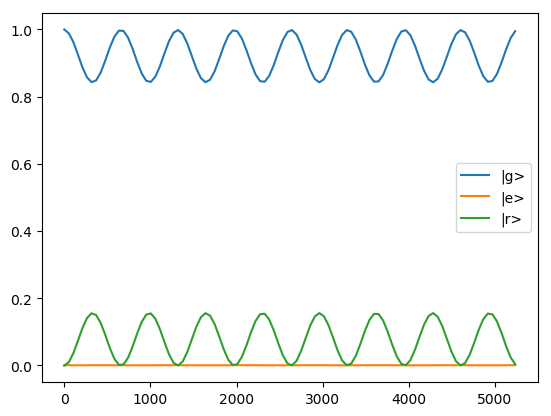

In [139]:
for s,l in zip(soln.y,['|g>','|e>','|r>']):
    plt.plot(soln.t,real(conjugate(s)*s),label=l)
plt.legend(loc='best')

## Rabi oscillations with RIN

In [14]:
## import actual RIN spectra
(f1,rin1), lbls1 = soln_from_csv(os.path.join('csv_analysis','soln_rin_780_20201223.csv'))

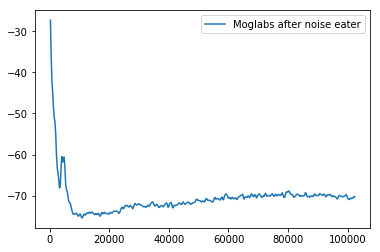

In [15]:
plt.plot(f1,real(rin1[1:]),label=lbls1[1])
# plt.plot(f,10*log10(x1[1:]/x1[0]), label=testlbls[1])
plt.legend()

In [22]:
## build time domain intensity function
int1 = lambda t: sum([sqrt(rin1[0]*10**(sx/10))*cos(2*pi*f*t+2*pi*rand.rand()) 
                      for f,sx in zip(f1,rin1[1:])]) # Fourier series

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


(0, 1.3)

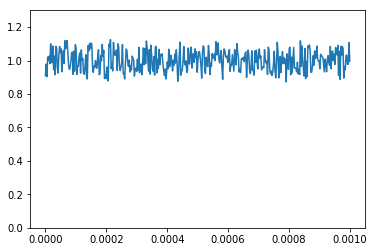

In [39]:
## time-domain intensity
fig,ax = plt.subplots()
# use enough time steps to resolve all frequency components
t_end = 0.001 # [s]
numpts = 4*int(t_end*max(f1))
t_steps = linspace(0,t_end,numpts)
int1_steps = real(array([int1(t)+rin1[0] for t in tsteps]))
int1_steps /= real(rin1[0]) # normalize to rin dc

ax.plot(tsteps, int1_steps)
ax.set_ylim((0,1.3))

In [79]:
## Rabi oscillation in two level atom
# the rabi frequency with noise is omega*(1+noise(t)) = omega*sqrt((dc + rin(t))/dc)

psi0 = array([1,0], complex) # population starts in |g>

delta = 0
omega = 2*pi*6e5 # the mean rabi frequency

# atom+field Hamiltonian, hbar=1
rabi = lambda t: omega*sqrt(real(int1(t)+rin1[0])/real(rin1[0]))
Haf = lambda t: array([[0,-rabi(t)/2],[-rabi(t)/2,delta]])
dpsi = lambda t,state: -1j*dot(Haf(t),state)

tmin = 0
tmax = 2*pi*10/omega
numpts = 4*int(t_end*max(f1))
tpts = linspace(tmin,tmax,numpts)

# get a average soln after multiple runs
avgs = 80
gsolns = empty((avgs,numpts),dtype=float)
for step in range(avgs):
    soln = solve_ivp(dpsi,[tmin,tmax],psi0,t_eval=tpts,vectorized=True)
    gsolns[step,:] = soln.y[0]

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


(0, 1.3)

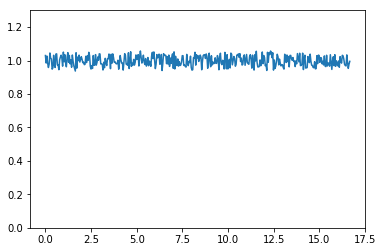

In [75]:
# the rabi frequency vs time
fig,ax = plt.subplots()
ax.plot(tpts/1e-6, [rabi(t)/omega for t in tpts])
ax.set_ylim((0,1.3))

In [80]:
avgsoln = sum(gsolns,axis=0)/avgs

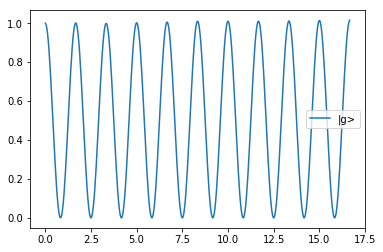

In [81]:
plt.plot(soln.t/1e-6,real(conjugate(avgsoln)*avgsoln),label='|g>')
plt.legend(loc='best')